We will use as an example some data from sensor.community

In [6]:
# !pip install pydantic ruyaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 5.1 MB/s eta 0:00:00
  Using cached ruyaml-0.91.0-py3-none-any.whl (108 kB)
  Using cached annotated_types-0.6.0-py3-none-any.whl.metadata (12 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.8/394.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.8 MB/s eta 0:00:00 MB/s eta 0:00:01
Using cached annotated_types-0.6.0-py3-none-any.whl (12 kB)
Using cached distro-1.9.0-py3-none-any.whl (20 kB)


In [92]:
# This takes a while to run
import requests 
data = requests.get("https://data.sensor.community/static/v1/data.json").json()

In [93]:
data[0]

{'id': 19320200764,
 'sampling_rate': None,
 'timestamp': '2024-02-21 15:11:02',
 'location': {'id': 48653,
  'latitude': '51.742',
  'longitude': '-1.256',
  'altitude': '57.8',
  'country': 'GB',
  'exact_location': 0,
  'indoor': 0},
 'sensor': {'id': 62054,
  'pin': '1',
  'sensor_type': {'id': 23, 'name': 'PMS5003', 'manufacturer': 'Plantower'}},
 'sensordatavalues': [{'id': 43878136464, 'value': '0', 'value_type': 'P2'},
  {'id': 43878136465, 'value': '0', 'value_type': 'P1'}]}

In [95]:
chipid = 532

[d for d in data if d["sensor"]["id"] == 5323531]

[]

## An example of a report that doesn't make sense
Here we're being given noise values but the sensor is being reported as SDS011
I believe this is an issue related to having multiple sensors connected to one esp32 but they API doesn't represent that case.

In [10]:
next(o for o in data
     if o["sensor"]["sensor_type"]["name"] == "SDS011"
    and any(p["value_type"] == "noise_LA_max" for p in o["sensordatavalues"])    
 )

{'id': 19317477734,
 'sampling_rate': None,
 'timestamp': '2024-02-21 10:28:31',
 'location': {'id': 69809,
  'latitude': '43.09823125000',
  'longitude': '-89.34557268665',
  'altitude': '262.3',
  'country': 'US',
  'exact_location': 1,
  'indoor': 0},
 'sensor': {'id': 79001,
  'pin': '1',
  'sensor_type': {'id': 14, 'name': 'SDS011', 'manufacturer': 'Nova Fitness'}},
 'sensordatavalues': [{'id': 43871688009,
   'value': '45.12',
   'value_type': 'noise_LAeq'},
  {'id': 43871688017, 'value': '39.59', 'value_type': 'noise_LA_min'},
  {'id': 43871688019, 'value': '49.35', 'value_type': 'noise_LA_max'}]}

## Parsing the data into a nicer format

In [11]:
from pydantic.dataclasses import dataclass
from typing import Literal, Any
from datetime import datetime

@dataclass(frozen = True)
class Location:
    id: int
    latitude: float | Literal["unavailable"]
    longitude: float | Literal["unavailable"]
    exact: bool
    altitude: float | None | str = None

@dataclass(frozen = True)
class Station:
    id: int
    pin: str

@dataclass(frozen = True)
class Sensor:
    id: int | Literal["unavailable"]
    name: str
    manufacturer: str

@dataclass(frozen = True)
class Property:
    value: Any
    id: int | None = None
    value_type: str | None = None

@dataclass(frozen = True)
class Observation:
    location: Location 
    sensor: Sensor
    station: Station
    properties: list[Property]


def format(d):
    try:
        return Observation(
            location = Location(**d["location"], exact = d.get("exact_location", 0)),
            sensor = Sensor(**d["sensor"]["sensor_type"]),
            station = Station(**d["sensor"]),
            properties = [Property(**r) for r in d["sensordatavalues"]],
        )
    except Exception as e:
        print(f"\n\nFailed on {d} with error \n {e}")

observations = [format(d) for d in data]

In [12]:
len(observations)

48546

## Break down by sensor

In [28]:
from collections import Counter
sensors = Counter(o.sensor for o in observations)
sensors

Counter({Sensor(id=14, name='SDS011', manufacturer='Nova Fitness'): 24029,
         Sensor(id=17, name='BME280', manufacturer='Bosch'): 10240,
         Sensor(id=9, name='DHT22', manufacturer='various'): 9352,
         Sensor(id=29, name='DNMS (Laerm)', manufacturer='Luftdaten.info'): 1082,
         Sensor(id=37, name='SPS30', manufacturer='Sensirion AG'): 771,
         Sensor(id=23, name='PMS5003', manufacturer='Plantower'): 533,
         Sensor(id=20, name='BMP280', manufacturer='Bosch'): 509,
         Sensor(id=27, name='SHT31', manufacturer='Sensirion AG'): 500,
         Sensor(id=22, name='PMS7003', manufacturer='Plantower'): 371,
         Sensor(id=8, name='BMP180', manufacturer='Bosch'): 287,
         Sensor(id=26, name='SHT30', manufacturer='Sensirion AG'): 283,
         Sensor(id=19, name='HTU21D', manufacturer='Measurement Specialties'): 215,
         Sensor(id=36, name='Radiation Si22G', manufacturer='EcoCurious'): 143,
         Sensor(id=13, name='DS18B20', manufacturer='Da

In [51]:
total = sum(sensors.values())

for s, number in sorted(sensors.items(), key = lambda s : -s[1]):
    print(f"#    {s.name:20} {number} {number/total*100:.0f}%")

#    SDS011               24029 49%
#    BME280               10240 21%
#    DHT22                9352 19%
#    DNMS (Laerm)         1082 2%
#    SPS30                771 2%
#    PMS5003              533 1%
#    BMP280               509 1%
#    SHT31                500 1%
#    PMS7003              371 1%
#    BMP180               287 1%
#    SHT30                283 1%
#    HTU21D               215 0%
#    Radiation Si22G      143 0%
#    DS18B20              89 0%
#    SHT35                20 0%
#    PMS1003              20 0%
#    NextPM               16 0%
#    GPS-NEO-6M           15 0%
#    HPM                  12 0%
#    PMS3003              12 0%
#    SCD30                10 0%
#    PPD42NS              9 0%
#    Radiation SBM-20     8 0%
#    Radiation SBM-19     7 0%
#    SDS021               6 0%
#    SHT85                4 0%
#    SHT11                2 0%
#    SHT15                1 0%


In [20]:
observed_properties = Counter(p.value_type for obs in observations for p in obs.properties)
observed_properties

Counter({'P1': 25649,
         'P2': 25649,
         'temperature': 21637,
         'humidity': 20775,
         'pressure': 11123,
         'pressure_at_sealevel': 11005,
         'P0': 1476,
         'noise_LAeq': 1087,
         'noise_LA_min': 1087,
         'noise_LA_max': 1087,
         'P4': 875,
         'N1': 856,
         'N05': 853,
         'N25': 521,
         'N10': 521,
         'N4': 517,
         'TS': 517,
         'counts_per_minute': 156,
         'counts': 140,
         'sample_time_ms': 140,
         'hv_pulses': 127,
         'co2_ppm': 18,
         'timestamp': 17,
         'lat': 15,
         'lon': 15,
         'height': 15,
         'durP1': 9,
         'ratioP1': 9,
         'durP2': 9,
         'ratioP2': 9,
         'pressure_sealevel': 2,
         'P3': 2,
         'interval': 2,
         'samples': 1,
         'min_micro': 1,
         'max_micro': 1,
         'brightness': 1})

In [26]:
for o in observed_properties:
    print(f"    {o:25} : {o}")

    temperature               : temperature
    pressure                  : pressure
    humidity                  : humidity
    pressure_at_sealevel      : pressure_at_sealevel
    P1                        : P1
    P2                        : P2
    noise_LAeq                : noise_LAeq
    noise_LA_min              : noise_LA_min
    noise_LA_max              : noise_LA_max
    P0                        : P0
    P4                        : P4
    N05                       : N05
    N1                        : N1
    N25                       : N25
    N4                        : N4
    N10                       : N10
    TS                        : TS
    counts_per_minute         : counts_per_minute
    hv_pulses                 : hv_pulses
    counts                    : counts
    sample_time_ms            : sample_time_ms
    durP1                     : durP1
    ratioP1                   : ratioP1
    durP2                     : durP2
    ratioP2                   : ratioP2
 

In [209]:
from collections import Counter
n = len(set(o.station for o in observations))
print(f"There are {n} unique stations in this dataset of {len(observations)} observations")

There are 22522 unique stations in this dataset of 48886 observations


In [194]:
[o for o in observations
     if o.sensor.name == "SDS011"
    and any(p.value_type == "noise_LA_max" for p in o.properties)    
]

[Observation(location=Location(id=69809, latitude=43.09823125, longitude=-89.34557268665, exact=False), sensor=Sensor(id=14, name='SDS011', manufacturer='Nova Fitness'), station=Station(id=79001, pin='1'), properties=[Property(value='49.44', id=43378486949, value_type='noise_LAeq'), Property(value='40.89', id=43378486950, value_type='noise_LA_min'), Property(value='67.70', id=43378486951, value_type='noise_LA_max')]),
 Observation(location=Location(id=69809, latitude=43.09823125, longitude=-89.34557268665, exact=False), sensor=Sensor(id=14, name='SDS011', manufacturer='Nova Fitness'), station=Station(id=79001, pin='1'), properties=[Property(value='44.36', id=43378462381, value_type='noise_LAeq'), Property(value='40.40', id=43378462386, value_type='noise_LA_min'), Property(value='49.75', id=43378462387, value_type='noise_LA_max')]),
 Observation(location=Location(id=69809, latitude=43.09823125, longitude=-89.34557268665, exact=False), sensor=Sensor(id=14, name='SDS011', manufacturer='No

In [280]:
from collections import defaultdict, Counter
from dataclasses import dataclass, asdict, field
import sys
import ruyaml as yaml

@dataclass
class SensorYAML:
    id: int
    name: str
    manufacturer: str
    description: str = ""
    uri: str = ""
    observed_properties: Counter = field(default_factory = Counter)
    

from collections import Counter
sensors = set(o.sensor for o in observations)
sensors = {s.name : SensorYAML(**asdict(s)) for s in sensors}

import ruyaml
yaml = ruyaml.YAML()
yaml.indent(mapping=2, sequence=4, offset=2)

for o in observations:
    for p in o.properties:
        sensors[o.sensor.name].observed_properties[p.value_type] += 1

for name, sensor in sensors.items():
    sensor.observed_properties = dict(sensor.observed_properties)

with open('sensors_auto_generated.yml', 'w') as outfile:
    yaml.dump({name : asdict(s) for name, s in sensors.items()}, 
              outfile)

for name, sensor in sensors.items():
    sensor.observed_properties = list(sensor.observed_properties.keys())

with open('sensors.yml', 'w') as outfile:
    yaml.dump({name : asdict(s) for name, s in sensors.items()}, 
              outfile)

In [5]:
import yaml
yaml = yaml.safe_load("""
sensor_platforms:
    - sensor_community_esp32:
    

sensors:
    -   uri: WGS84_lat_lon_alt
        name: WGS84 latitude longitude altidue 
        
    -   uri: BME280
        name: BME280
        manufacturer: Bosch
    
        observes:
            - pressure
            - temperature
            - relative_humidity

    -   uri: sds011
        name: sds011
        manufacturer: ????

        observes:
            - pressure
            - temperature
            - relative_humidity

observables:
    - name: pressure
      unit: Pa
    - name: temperature
      unit: K

""")

In [9]:
!pip install geodatasets contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 6.3 MB/s eta 0:00:00m eta 0:00:010:00:01


In [27]:
import geopandas
import geodatasets
import contextily as cx

import matplotlib.pyplot as plt

import xarray as xr 

ds = xr.open_dataset("./Sofia_PM25_hres_202212.nc")
delta = int(0.1 / 0.0025)

coarse_rob = ds.coarsen(lon=delta, lat=delta, boundary='trim').mean()
coarse_rob

<xarray.Dataset>
Dimensions:  (lat: 3, lon: 3)
Coordinates:
  * lon      (lon) float64 23.25 23.35 23.45
  * lat      (lat) float64 42.55 42.65 42.75
Data variables:
    rob_val  (lat, lon) float64 18.84 18.39 17.64 16.18 ... 22.22 26.25 22.53
    rob_var  (lat, lon) float64 210.6 170.0 136.4 77.76 ... 153.1 198.9 189.1

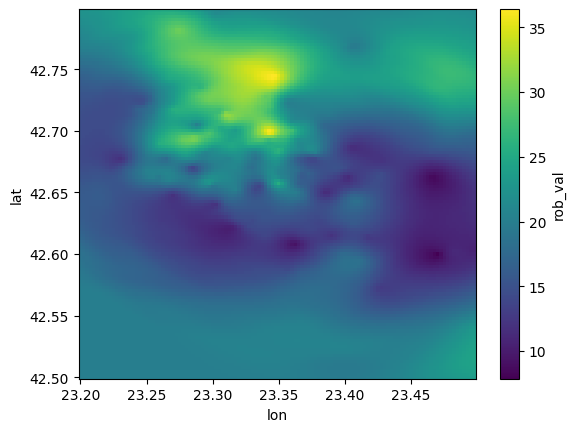

In [52]:
df

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."


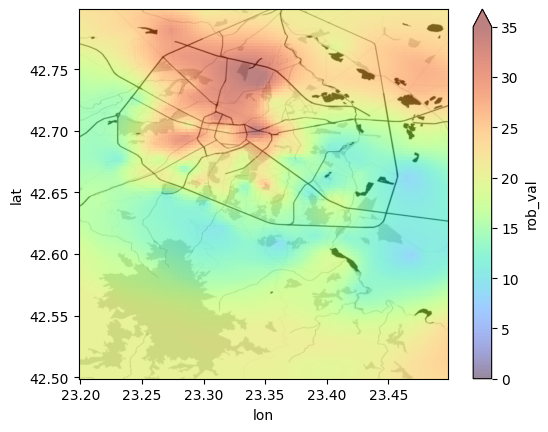

In [66]:
# Create a dataframe with the New York boroughs sample dataset
fig, ax = plt.subplots()

# Define the plot size, transparency, and edge color
# ax = df.plot(ax=ax, figsize=(10, 10), alpha=0.5, edgecolor="k")

ds["rob_val"].plot(ax = ax, alpha = 0.5, cmap = "turbo", vmin = 0, vmax = 35)

# Draw the basemap under the plot, define the Coordinate Reference System, and add the XYZ Stamen Terrian style (don't forget to add your API key)
cx.add_basemap(ax, crs="EPSG:4326", zorder=-1, alpha = 1,
               source='https://tiles.stadiamaps.com/tiles/stamen_toner_background/{z}/{x}/{y}{r}.png?api_key=2465c884-87df-4898-8a98-352ae6dc4175')

# cx.add_basemap(ax, zorder = 10, crs="EPSG:4326", alpha = 1,
#                source='https://tiles.stadiamaps.com/tiles/stamen_toner_labels/{z}/{x}/{y}{r}.png?api_key=2465c884-87df-4898-8a98-352ae6dc4175')


ax.set(
    xlabels = ""
    xticks = []
)

fig.savefig("test.svg")

In [58]:
cx.add_basemap?

Signature:
cx.add_basemap(
    ax,
    zoom='auto',
    source=None,
    interpolation='bilinear',
    attribution=None,
    attribution_size=8,
    reset_extent=True,
    crs=None,
    resampling=<Resampling.bilinear: 1>,
    zoom_adjust=None,
    **extra_imshow_args,
)
Docstring:
Add a (web/local) basemap to `ax`.

Parameters
----------
ax : AxesSubplot
    Matplotlib axes object on which to add the basemap. The extent of the
    axes is assumed to be in Spherical Mercator (EPSG:3857), unless the `crs`
    keyword is specified.
zoom : int or 'auto'
    [Optional. Default='auto'] Level of detail for the basemap. If 'auto',
    it is calculated automatically. Ignored if `source` is a local file.
source : xyzservices.TileProvider object or str
    [Optional. Default: OpenStreetMap Humanitarian web tiles]
    The tile source: web tile provider, a valid input for a query of a
    :class:`xyzservices.TileProvider` by a name from ``xyzservices.providers`` or
    path to local file. The web 

In [1]:
import requests 
data = requests.get("https://data.sensor.community/static/v1/data.json").json()
next(o for o in data
     if o["sensor"]["sensor_type"]["name"] == "SDS011"
    and any(p["value_type"] == "noise_LA_max" for p in o["sensordatavalues"])    
 )

NameError: name 'data' is not defined

In [89]:
url = "http://localhost:5002/api/retrieve?class=rd&date=20220616&expver=xxxx&stream=iot&time=1800&platform=meteotracker&project=I-CHANGE&observation_variable=air_temperature_near_surface"

headers = {
    'Accept': 'application/octet-stream'
}

r = requests.get(url, headers = headers)

from IPython.display import display, HTML
HTML(r.bytes)

AttributeError: 'Response' object has no attribute 'bytes'